# Mapper from Scratch
The purpose of this  notebook is to run through the mapper algorithm piece by piece using python. Each of the major steps of the mapper algorithm are then outlined below. We will fill them in as we go.

## Our Data

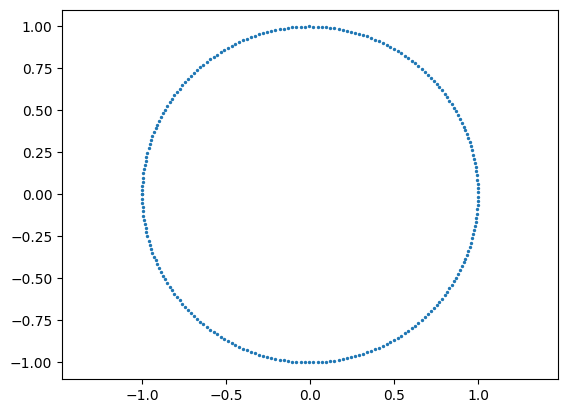

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 250

data = np.empty((N,2))

theta = np.linspace(-np.pi, np.pi, N)

data[:,0] = np.cos(theta)
data[:,1] = np.sin(theta)

plt.scatter(data[:,0],  data[:,1], s=2)
_ = plt.axis("equal")

## Dimension reduction

The first step of mapper is to use a lens function to map our data to a lower dimensional feature space. Here we will project onto the first principle component.

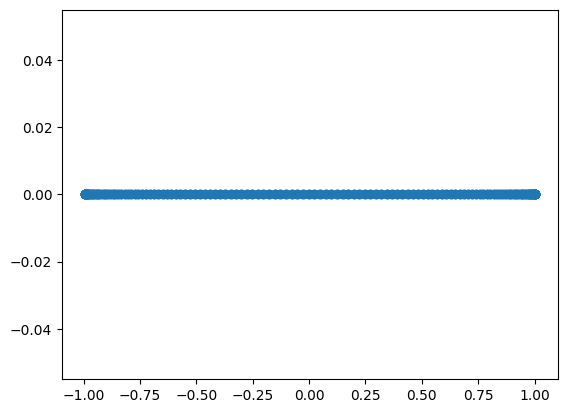

In [2]:
from sklearn.decomposition import PCA

lens = PCA(n_components=1)

feature_space = lens.fit_transform(data)

_ = plt.scatter(feature_space, np.zeros_like(feature_space))

## Cover Feature Space

Next with this dimension reduction complete we cover our feature space. For this example we will construct a cover with equal width elements and 25% overlap.

### Construct intervals

We start by constructing our intervals. If we want $n$ intervals of the form $[a_i, b_i]$ where $i = 0, 1, 2,\ldots,n$ with overlap $p$. We define $a = \min(\text{feature space})$, $b = \max(\text{feature space})$ then we can define:
$$
w = \frac{b - a}{n - (n-1)p} \quad\text{and}\quad a_i = a + iw(1-p) \quad\text{and}\quad b_i = a_i + w
$$

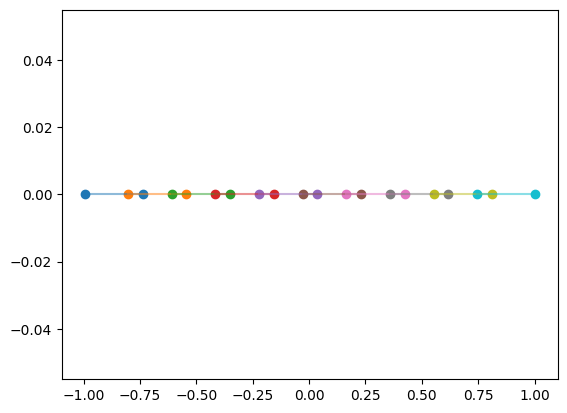

In [3]:
n = 10
p = 0.25

a = np.min(feature_space)
b = np.max(feature_space)

w = (b-a) / ( n - (n-1) * p )

# We define limits to be an array such that
# limits[i] = [a_i, b_i]

limits = np.empty((n,2))
n = np.arange(n)
limits[:,0] = a + n * w * (1-p)
limits[:,1] = limits[:,0] + w

# Some sanity checks to convince us this is doing the right thing

assert np.all(np.isclose(limits[:,1] - limits[:,0], w))      # Each interval is w wide
assert np.all(np.isclose(limits[:-1,1] - limits[1:,0], w*p)) # The overlap of each interval is w*p

for i, lim in enumerate(limits):
    plt.plot(lim, np.full_like(lim, 0), alpha=0.5)
    plt.scatter(lim, np.full_like(lim, 0))

### Bin feature space

Now that we have our cover of feature space we would like to figure out which points lie in each bin.

#### Example

To start we will show an example of what this looks like. We will compute all the points which lie within the third cover element. We will represent the cover element as the list of indices of the data points within that cover.

In [4]:
i = 2 # We are looking at the third cover element

np.flatnonzero(                       # Returns the indices of the array which are true
    np.logical_and(                   # Makes sure both conditions hold
        limits[i,0] <= feature_space, # Which data points lie above a_i
        limits[i,1] >= feature_space, # Which data points lie below b_i
    )
)

array([ 37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 212])

We then can loop over all values of $i$ to construct our cover.

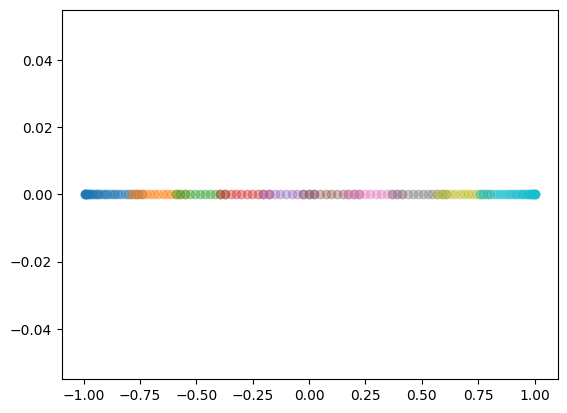

In [5]:
cover = [
    np.flatnonzero(
        np.logical_and(
            limits[i,0] <= feature_space, 
            limits[i,1] >= feature_space
        )
    )
    for i in n
]

for i, element, in enumerate(cover):
    plt.scatter(feature_space[element], np.full_like(element, 0), alpha=0.2)

## Pullback Cover

We then pullback the cover. There is actually nothing to do here, this is just to illustrate what's happening.

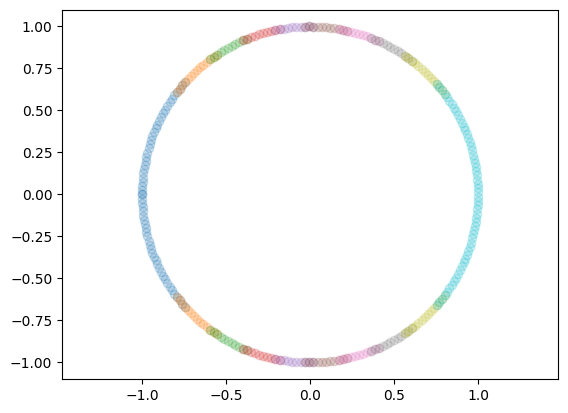

In [6]:
for element in cover:
    pullback = data[element] # This is all we have to do to pull our data back!
    plt.scatter(pullback[:,0], pullback[:,1], alpha=0.2)

_ = plt.axis("equal")

## Cluster Cover Elements

We now cluster this pullback to inject a notion of connectedness.

### Example of clustering

Continuing our example where we look at the third cover element, we will examine what clustering the third cover element looks like.

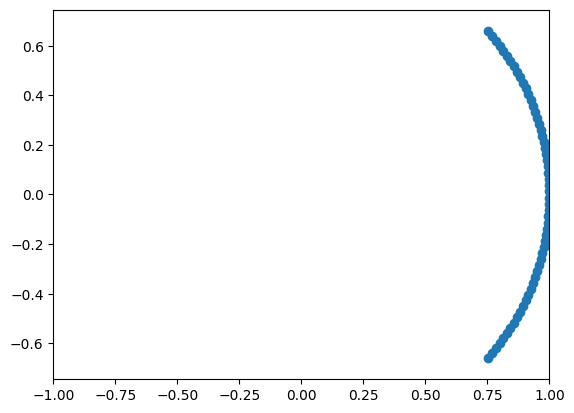

In [7]:
from sklearn.cluster import DBSCAN

clusterer = DBSCAN( eps = 0.1, min_samples = 1 )

# i = 2
pullback = data[cover[i]]

labels = clusterer.fit_predict(pullback)

for label in set(labels):               # For each unique label
    cluster = pullback[labels == label] # Extracts the points in that label
    plt.scatter(cluster[:,0], cluster[:,1])
    
plt.axis("equal")
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()

### Computing the clusters

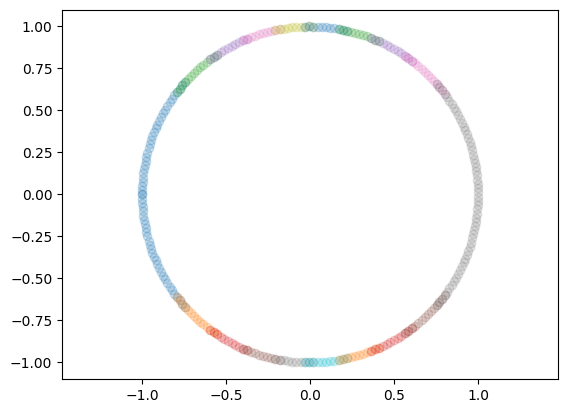

In [8]:
def compute_clusters():
    # This is done as a function so we can yield the clusters as we find them then condense it into a list later
    for element in cover:
        labels = clusterer.fit_predict(data[element]) # Where pullback happens
        yield from ( element[labels == label] for label in set(labels) )
        
clusters = list(compute_clusters())

for cluster in clusters:
    pullback = data[cluster]
    plt.scatter(pullback[:,0], pullback[:,1], alpha=0.2)

_ = plt.axis("equal")

## Compute the Nerve

Finally we compute the nerve of the cluster cover we just computed

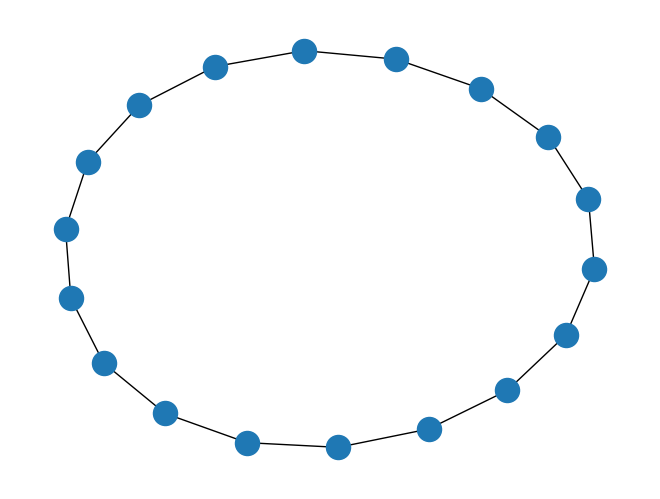

In [9]:
import networkx as nx
from itertools import combinations

frozen_clusters = map(frozenset, clusters) # We have to use a frozen set so we can use the nodes as labels in our graph

g = nx.Graph()

for a, b in combinations(frozen_clusters, r=2):
    g.add_node(a)
    g.add_node(b)
    if frozenset.intersection(a,b):
        g.add_edge(a,b)
    
nx.draw(g)
plt.show()

# That's pretty much it!

If you would like to explore a bit more, try messing with the values $n$ and $p$ in the cell about the cover. Making $p \geq 0.5$ or $p \leq 0.05$ leads to interesting results which may help sharpen your intuition of mapper.